## Analyzing the retention of a feature in a mobile app

### Key findings

- Weekly retention of the feature is improving for newer cohorts
- Weekly retention is better for users that start using the app during the Spring or during the Winter
- Users from countries such as GB, CH, US, NL and BE have better weekly retention than others, but it does not translate to a better long-term retention
- Users that record activities in sports such as "jogging", "nordicwalking" and "citybike" have better weekly retention
- Users that record activities in more than one sport have better weekly retention

The analysis process is described below in detail.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib.style as style
style.use('seaborn-poster')
sns.set(style='white')

### Importing the dataset

I'll start by importing the dataset and taking a quick look at it.

In [4]:
tour_events = pd.read_csv('events', parse_dates=['timestamp'])

In [5]:
tour_events.head()

,timestamp,user,sport,country
0,2016-05-24 07:00:00,1e9f3dd30b29d301f553,hike,DE
1,2018-08-31 16:00:00,9a012831aff9bc97fa0e,hike,DE
2,2018-07-15 15:00:00,49f52d235b8fd0f2edd5,jogging,AT
3,2018-08-30 17:00:00,21af0f3bdf13bd355d77,touringbicycle,GB
4,2018-08-28 10:00:00,9f84ae437d5179012809,touringbicycle,DE


There are a few records without an associated sport and/or country. To simplify the analysis, I'll drop records that have at least one column missing.

In [6]:
tour_events.isnull().mean()

timestamp    0.000000e+00
user         0.000000e+00
sport        4.398011e-07
country      4.354427e-02
dtype: float64

In [7]:
tour_events.dropna(inplace=True)

In [8]:
tour_events.isnull().mean()

timestamp    0.0
user         0.0
sport        0.0
country      0.0
dtype: float64

Finally, before getting started, I wanted to confirm a few assumptions about the dataset to avoid mistakes later on.

1. Users can - and usually have - more than one record

In [9]:
tour_events['user'].shape[0] / tour_events['user'].unique().shape[0]

17.671092404199303

2. Records start on 2011-01 and finish on 2019-04

In [10]:
tour_events['timestamp'].min(), tour_events['timestamp'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2019-04-30 23:59:59'))

3. Users can have records with different sports, and it is quite common

In [11]:
user_sports = tour_events.pivot_table(index='user', 
                                      columns='sport',
                                      aggfunc='size',
                                      fill_value=0)

In [12]:
user_sports['total'] = sum([(user_sports[sport] > 0).astype(int) for sport in tour_events['sport'].unique()])

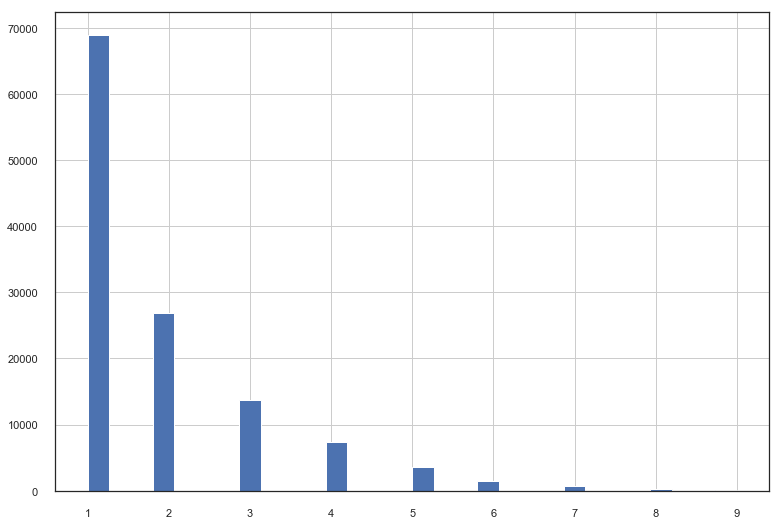

In [13]:
user_sports[user_sports['total'] < 10]['total'].hist(bins=30)

4. Users can have records with different countries, though it is not common

In [14]:
user_countries = tour_events.pivot_table(index='user', 
                                         columns='country',
                                         aggfunc='size',
                                         fill_value=0)

In [15]:
user_countries['total'] = sum([(user_countries[country] > 0).astype(int) for country in tour_events['country'].unique()])

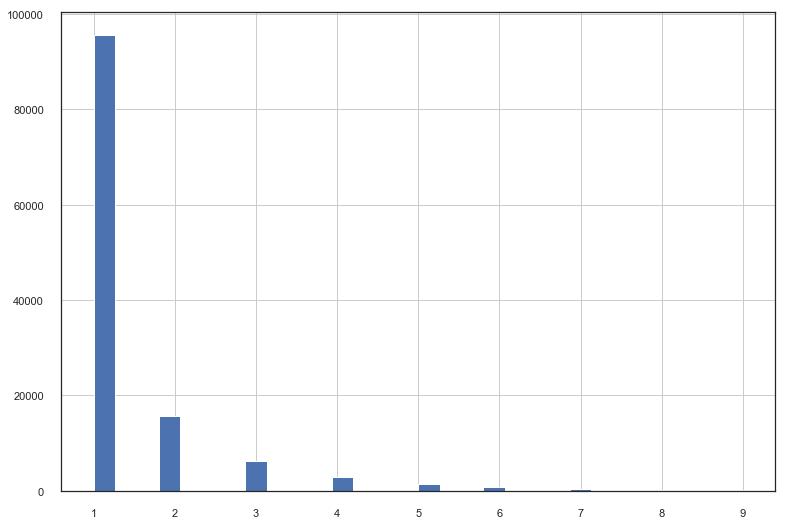

In [16]:
user_countries[user_countries['total'] < 10]['total'].hist(bins=30)

### Finding the "natural rhythm"

To properly analyze the retention of cohorts, I wanted to start by finding the current "natural rhythm" that users follow when using the app. For instance, if it is common for users to record adventures once per day, it could make sense to look at daily retention. On the other hand, it may the case that users actually record adventures once per month, which would make a daily retention chart useless. Understanding the current rhythm will help me avoid this issue.

The main idea is to find the usual gap between events for the same user.

In [17]:
tour_events.sort_values(by=['user', 'timestamp'], ascending=True, inplace=True)

In [18]:
tour_events['previous_user'] = tour_events.user.shift()

In [19]:
tour_events['gap'] = tour_events['timestamp'].diff().dt.days

In [20]:
tour_events.sort_values(by='gap', ascending=True, inplace=True)

Ignoring events that happen within less than one day of each other, it seems that 65% of consecutive events for the same user happen within 7 days of each other. In other words, for now, I'll start by looking at weekly retention cohorts.

As I explain later, I'll play around with this rhythm to find some interesting patterns in the data.

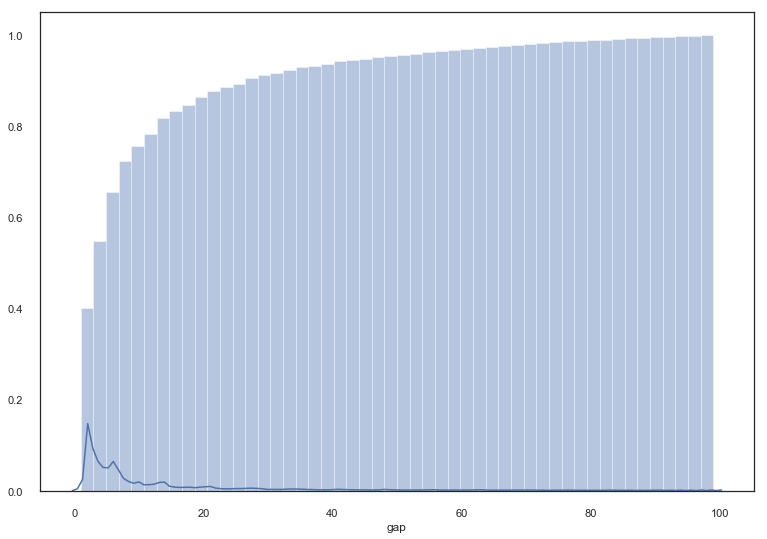

In [21]:
sns.distplot(tour_events[(tour_events['user'] == tour_events['previous_user']) &\
                         (tour_events['gap'] > 0) &\
                         (tour_events['gap'] < 100)]['gap'],
             hist_kws={'cumulative': True})

In [22]:
tour_events[(tour_events['user'] == tour_events['previous_user']) & (tour_events['gap'] <= 7) & (tour_events['gap'] > 0)].shape[0] /\
tour_events[(tour_events['user'] == tour_events['previous_user']) & (tour_events['gap'] > 0)].shape[0]

0.6570369706162175

### Analyzing the weekly retention of yearly cohorts

My goal now is to plot in a heatmap the weekly retention for different cohorts. I'll do this "manually" once, then generalize the process into a function that I can easily replicate for different scenarios.

In [23]:
tour_events.set_index('user', inplace=True)

In [24]:
tour_events['first_event'] = tour_events.groupby(level=0)['timestamp'].min()

In [25]:
tour_events.head()

,timestamp,sport,country,previous_user,gap,first_event
user,,,,,,
4c45178603ad2aa09542,2011-01-04 08:00:00,hike,DE,4c443618ebf1377986bf,-3039.0,2011-01-04 08:00:00
86397d95e5ec2c40d3af,2011-01-01 02:00:00,hike,DE,86394229a42ca41bcb8f,-3036.0,2011-01-01 02:00:00
0b02dd5ac48523fe9ddb,2011-01-08 12:00:00,racebike,DE,0b01cf47a2120231f6da,-3035.0,2011-01-08 12:00:00
233fac7c6c0e78172374,2011-01-01 01:00:00,hike,DE,233f3c06fe7b3fa3f91f,-3034.0,2011-01-01 01:00:00
f0ac144dd117e76da515,2011-01-16 00:00:00,other,DE,f0ab7e334c71fb7744e4,-3026.0,2011-01-16 00:00:00


In this analysis, the "period" will mean how many weeks after its first record a user re-did the same event e.g. a period of 1 means that this particular event happened in the second week following the user's "activation".

In [26]:
tour_events['period'] = (tour_events['timestamp'] - tour_events['first_event']).dt.days // 7

Also, for the moment, I'll break the users into cohorts based on the year of their first event. I'll do this to analyze if retention seems to be improving over time for newer cohorts.

In [27]:
def cohort_criteria(df):
    return df.groupby(level=0)['timestamp'].min().apply(lambda x: x.strftime('%Y'))

In [28]:
tour_events['cohort'] = cohort_criteria(tour_events)

In [29]:
tour_events.reset_index(inplace=True)

In [30]:
grouped = tour_events.groupby(['cohort', 'period'])

In [31]:
cohorts = grouped.agg({'user': pd.Series.nunique})

In [32]:
cohorts.rename(columns={'user': 'total_users'}, inplace=True)

In [33]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort', 'period'], inplace=True)

For instance, the cohort of accounts created in 2011 has 679 users, of which 69 came back in the second week, and so on.

In [34]:
cohorts.head()

total_users
cohort period             
2011   0               679
       1                69
       2                59
       3                53
       4                39

In [35]:
cohort_size = cohorts['total_users'].groupby(level=0).first()

To arrive at a retention heatmap, it makes sense to look at retention as the percentage of accounts that came back, based on the cohort size.

In [36]:
retention = cohorts['total_users'].unstack(0).divide(cohort_size, axis=1).T.sort_index()[range(1, 24)]

For example, in the chart below, 10% of accounts which "activated" in 2011 came back after one week to register another adventure.

There is clearly a pattern of improvement for newer cohorts. The 2019 cohort seems to regress a little, but one has to be careful, since the dataset finishes on 2019-04. Seasonality plays a key role in retention, which means that 2019's numbers will likely improve as the year goes on.

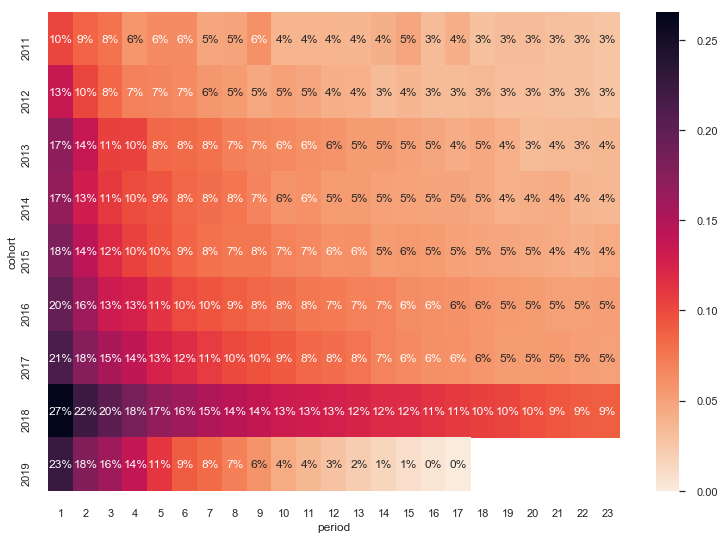

In [37]:
cmap = sns.cm.rocket_r
sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.0%', cmap = cmap)

There a few different ways of creating a retention chart. One of them is using what is known as "unbounded retention". It means, for example, that if a user came back only on the third week, it should still count as "retained" in the weeks before.

I re-did the chart above using the definition of "unbounded retention" but, for the sake of this report, I'll use the previous definition, since rhythm - or stickiness of the app - is important and we want to take that into account.

In [38]:
unbounded_retention = cohorts['total_users'].unstack(0).divide(cohort_size, axis=1)\
                      .sort_index(ascending=False).cummax().sort_index(ascending=True).T.sort_index()[range(1, 24)]

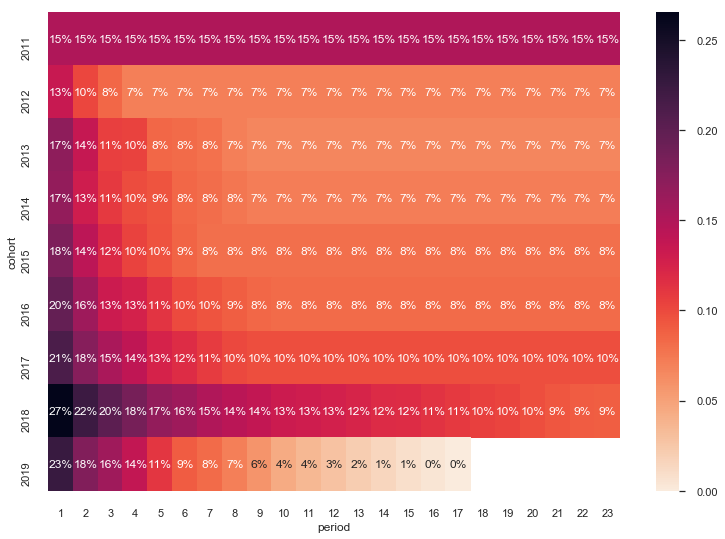

In [39]:
sns.heatmap(unbounded_retention, mask=unbounded_retention.isnull(), annot=True, fmt='.0%', cmap = cmap)

Now that I can generate a retention heatmap for a given cohort "criteria", I created a function to make the process a bit simpler and let me explore the data faster. This functions takes as arguments:

- The DataFrame of events
- The function to separate accounts into cohorts
- The frequency i.e. the rhythm that I want to analyze. For instance, "28" would mean "monthly retention"
- Whether I want to use the "unbounded" definition of retention
- The explicit order of the y-axis. I'll use this later to order countries from largest user base, to smallest
- The function to filter accounts. I'll use this later to analyze the improvement of retention over time, for a specific country

In [40]:
def retention_by_cohorts(tour_events, cohort_criteria, frequency=7, 
                         unbounded=False, order=None, filter=None):
    events = tour_events.copy()
    if filter:
        events = filter(events)
    events.set_index('user', inplace=True)
    events['first_event'] = events.groupby(level=0)['timestamp'].min()
    events['period'] = (events['timestamp'] - events['first_event']).dt.days // frequency
    events['cohort'] = cohort_criteria(events)
    events.reset_index(inplace=True)
    grouped = events.groupby(['cohort', 'period'])
    cohorts = grouped.agg({'user': pd.Series.nunique})
    cohorts.rename(columns={'user': 'total_users'}, inplace=True)
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['cohort', 'period'], inplace=True)
    cohort_size = cohorts['total_users'].groupby(level=0).first()
    if not unbounded:
        retention = cohorts['total_users'].unstack(0).divide(cohort_size, axis=1).T.sort_index()
    else:
        retention = cohorts['total_users'].unstack(0).divide(cohort_size, axis=1)\
                    .sort_index(ascending=False).cummax().sort_index(ascending=True).T.sort_index()
    if order:
        retention = retention.loc[order]
    retention = retention[range(1, min([24, max(retention.columns)]))]
    return sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.0%', cmap = cmap)

### Analyzing the relationship between seasons and retention

To start playing around with the function, I wanted to test an hypothesis that the seasons affect the retention. Assuming most users come from countries in the northern hemisphere, I can easily define the season based on the day_of_year.

In [41]:
def season(day_of_year):
    if day_of_year in range(80, 172):
        return 'Spring'
    elif day_of_year in range(172, 264):
        return 'Summer'
    elif day_of_year in range(264, 355):
        return 'Fall'
    return 'Winter'

In [42]:
def cohort_criteria(df):
    return df['first_event'].dt.dayofyear.astype(int).apply(season)

Based on the chart below, the weekly retention is better for users that start using the app during the Spring or during the Winter.

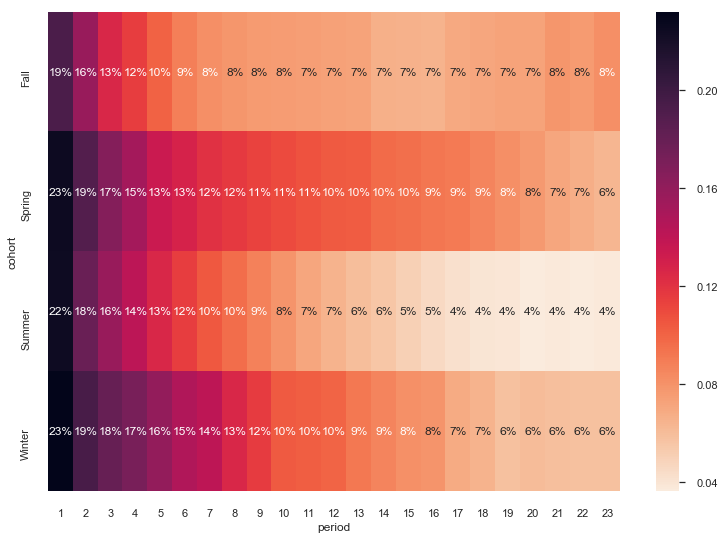

In [43]:
retention_by_cohorts(tour_events, cohort_criteria)

### Analyzing the relationship between countries and retention

Users can register adventures in more than one country, but to simplify the analysis, I assigned an user to the country where it registered the highest number of adventures.

In [44]:
user_countries['user_country'] = user_countries[[column for column in user_countries.columns if column != 'total']].idxmax(axis=1)

In [45]:
user_countries.reset_index(inplace=True)

In [46]:
top_countries = user_countries.groupby('user_country').count()['user'].sort_values(ascending=False).head(10).index.to_list()

In [47]:
user_countries['user_country'].replace({country: 'Others' for country in user_countries['user_country'].unique() if country not in top_countries},
                                       inplace=True)

In [48]:
tour_events = tour_events.merge(user_countries[['user', 'user_country']], on='user', how='left')

In [49]:
def cohort_criteria(df):
    return df['user_country']

The cohort below has countries ordered from the highest to the lowest number of users. Also, to control the size of the chart, I grouped countries with less users into a single category, since the distribution seemed to follow the Paretto Principle.

Clearly, some countries have better weekly retention than others, particularly countries such as GB, CH, US, NL and BE. That said, this could be a bit misguided, since some of these countries did not have users back in 2011, when the retention was worse.

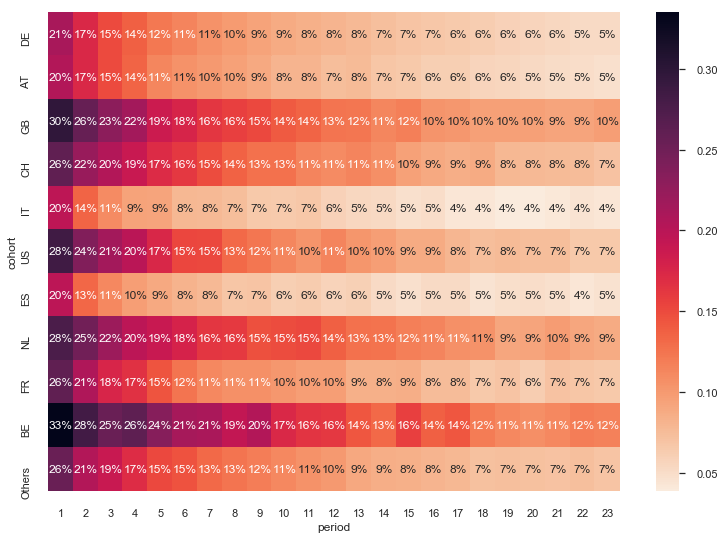

In [50]:
retention_by_cohorts(tour_events, cohort_criteria, order=top_countries + ['Others'])

In [51]:
def filter(df):
    return df[df['first_event'] >= datetime(2018, 1, 1)].copy()

Looking only at accounts created after 2018-01, the difference between countries still exists.

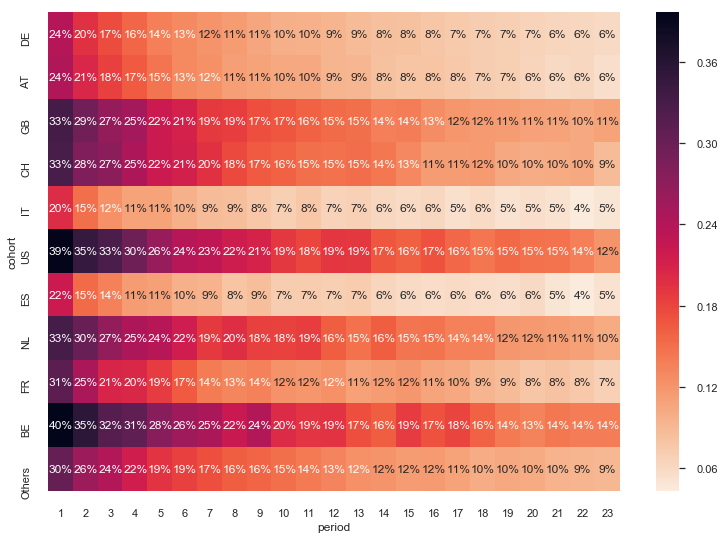

In [52]:
retention_by_cohorts(tour_events, cohort_criteria, order=top_countries + ['Others'], filter=filter)

To be sure, I also looked at monthly cohorts, and the conclusion is a bit different. Looking at the long-term retention, the numbers are roughly the same for different countries, and some of the countries I had previously mentioned - such as the US - have particularly bad long-term retention.

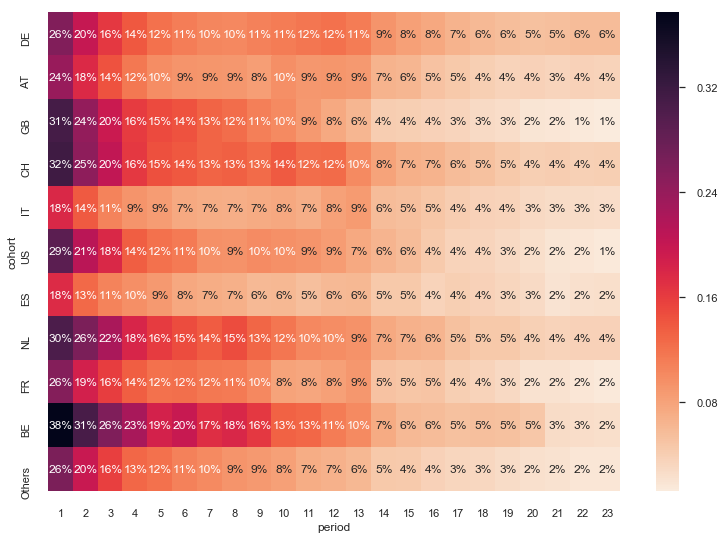

In [53]:
retention_by_cohorts(tour_events, cohort_criteria, frequency=28, order=top_countries + ['Others'])

### Analyzing the relationship between sports and retention

Finally, I also wanted to look at the relationship between "retention" and sports. I associated an user with a sport based on the number of registered adventures per sport. In other words, if a given user has more registrations for "hiking", this will be the cohort he or she will belong to.

In [54]:
user_sports['user_sport'] = user_sports[[column for column in user_sports.columns if column != 'total']].idxmax(axis=1)
user_sports.reset_index(inplace=True)
top_sports = user_sports.groupby('user_sport').count()['user'].sort_values(ascending=False).head(10).index.to_list()
user_sports['user_sport'].replace({sport: 'Others' for sport in user_sports['user_sport'].unique() if sport not in top_sports},
                                  inplace=True)
tour_events = tour_events.merge(user_sports[['user', 'user_sport']], on='user', how='left')

In [55]:
def cohort_criteria(df):
    return df['user_sport']

As before, the chart is ordered from sports with higher number of users, to lower number of users.

Clearly, some sports have higher retention, particularly "jogging", "nordicwalking" and "citybike".

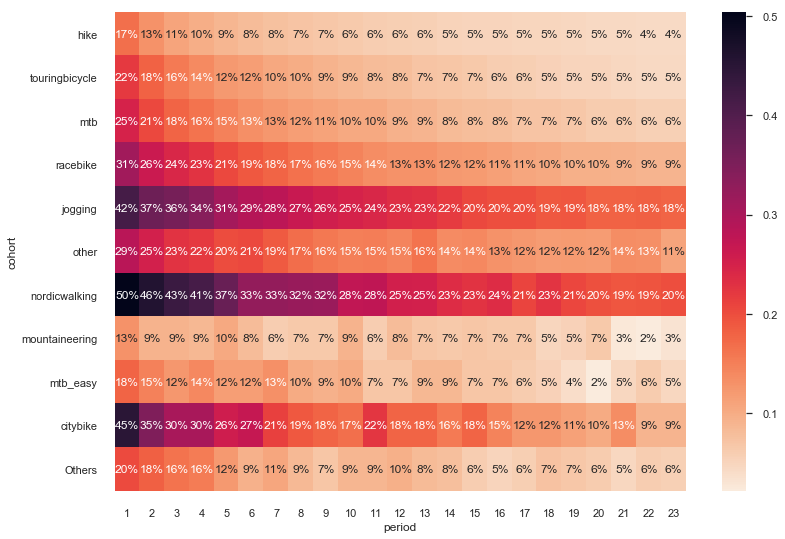

In [56]:
retention_by_cohorts(tour_events, cohort_criteria, order=top_sports + ['Others'])

Also, I also wanted to look at the hypothesis that users that register more than one sport have higher retention.

In [57]:
user_sports['total'] = user_sports['total'].astype(str)

In [58]:
user_sports['total'].replace({value: '> 5' for value in user_sports['total'].unique() if int(value) > 5},
                             inplace=True)

In [59]:
tour_events = tour_events.merge(user_sports[['user', 'total']], on='user', how='left')

In [60]:
def cohort_criteria(df):
    return df['total']

Clearly, that seems to be the case, as weekly retention goes up as the number of sports increases, which was expected.

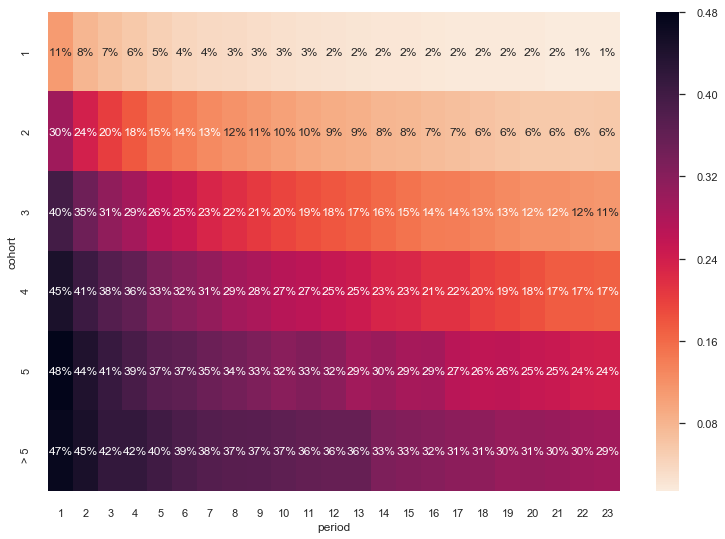

In [61]:
retention_by_cohorts(tour_events, cohort_criteria)

### Analyzing the improvement of monthly retention for users in specific countries

Finally, I wanted to make it a bit easier to analyze, for instance, whether the retention of users from a specific country - such as DE - is improving over time.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

Working on top of the retention_by_cohorts function, I added a simple feature to filter the dataset by country and also change the frequency of the cohort in an interactive manner. In the default example below, I'm looking at the monthly retention of users from DE. The chart will automatically update if you choose a different country and/or frequency.

What is particularly intersting about this chart is the seasonality of monthly retention. It starts high, then goes down, then goes up, then goes down, and so on, which is not common and is probably related to the app's use case. Also, it is clear that retention is improving over time for DE.

In [ ]:
def cohort_criteria(df):
    return df.groupby(level=0)['timestamp'].min().apply(lambda x: x.strftime('%Y'))

In [ ]:
@interact
def show_articles_more_than(country=top_countries, frequency=(7, 56, 7)):
    def filter(df):
        return df[(df['user_country'] == country)].copy()
    return retention_by_cohorts(tour_events, cohort_criteria, frequency=frequency, filter=filter)